In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
# import sys
import os


args = 2
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from distrax._src.distributions.distribution import Distribution
from distrax._src.bijectors.bijector import Bijector

Selected GPU 2


In [3]:
import sys
sys.path.append('/home/davcic/CP_Testing')
from New_kernel_1 import Discontinuous_multiple

In [4]:
import sys
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult

In [5]:
# pd_all = []
# print(pd_all)
# pd_all.append([])
# print(pd_all)
# pd_all.append([])
# print(pd_all)
# print(pd_all[0])

# pd_all[0].append([])
# print(pd_all)
# pd_all[0].append([])
# print(pd_all)
# pd_all[0][0].append(3)
# print(pd_all)
# print(pd_all[0])

In [6]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.fftpack import next_fast_len  # type: ignore

# from blackjax.types import Array, ArrayLike

def potential_scale_reduction(
    input_array, chain_axis: int = 0, sample_axis: int = 1
):
    """Gelman and Rubin (1992)'s potential scale reduction for computing multiple MCMC chain convergence.

    Parameters
    ----------
    input_array:
        An array representing multiple chains of MCMC samples. The array must
        contains a chain dimension and a sample dimension.
    chain_axis
        The axis indicating the multiple chains. Default to 0.
    sample_axis
        The axis indicating a single chain of MCMC samples. Default to 1.

    Returns
    -------
    NDArray of the resulting statistics (r-hat), with the chain and sample dimensions squeezed.

    Notes
    -----
    The diagnostic is computed by:

    .. math:: \\hat{R} = \\frac{\\hat{V}}{W}

    where :math:`W` is the within-chain variance and :math:`\\hat{V}` is the posterior variance
    estimate for the pooled traces. This is the potential scale reduction factor, which
    converges to unity when each of the traces is a sample from the target posterior. Values
    greater than one indicate that one or more chains have not yet converged :cite:p:`stan_rhat,gelman1992inference`.

    """
    assert (
        input_array.shape[chain_axis] > 1
    ), "potential_scale_reduction as implemented only works for two or more chains."

    num_samples = input_array.shape[sample_axis]
    # Compute stats for each chain
    per_chain_mean = jnp.nanmean(input_array, axis=sample_axis, keepdims=True)
    per_chain_var = jnp.nanvar(input_array, axis=sample_axis, ddof=1, keepdims=True)
    # Compute between-chain stats
    between_chain_variance = num_samples * per_chain_mean.var(
        axis=chain_axis, ddof=1, keepdims=True
    )
    # Compute within-chain stats
    within_chain_variance = per_chain_var.mean(axis=chain_axis, keepdims=True)
    # Estimate of marginal posterior variance
    rhat_value = jnp.sqrt(
        (between_chain_variance / within_chain_variance + num_samples - 1)
        / (num_samples)
    )
    return rhat_value.squeeze()

### Since this is not within the class, you will have to construct the class with the parameters yourself before testing convergence

In [7]:
size = 10
T = 1
max_CP = size
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)

priors = dict(kernel=dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                          variance=LogNormal_mod(0., 1, max_CP+1), 
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
            #   diag = dict(scale = LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())))

In [8]:
sys.path.append('/home/davcic/CP_Testing/Classes')
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1000
num_mcmc_steps = 1000
GP_latent = GP_CP_Latent(x, x, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)
GP_marginal = GP_CP_Marginal(x, x, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [9]:
def get_particle_vals(particles, num_particles, f_len, num_CP, num_runs):
    f_all = jnp.zeros((num_particles, f_len, num_runs))
    # num_all = jnp.zeros((num_particles, num_CP, num_runs))
    # len_all = jnp.zeros((num_particles, num_CP+1, num_runs))
    # var_all = jnp.zeros((num_particles, num_CP+1, num_runs))
    kernel_all = []
    if isinstance(particles[0]['kernel'], list):
        for j in range(len(particles['kernel'])):
            kernel_all.append([])
            for k, (key2, value2) in enumerate(particles[0]['kernel'][j].items()):
                 kernel_all[j].append([])
    else:
         for k, (key2, value2) in enumerate(particles[0]['kernel'].items()):
                 kernel_all.append([])
    obs_all = jnp.zeros((num_particles, num_runs))

    hyper_all = []
    if isinstance(particles[0]['hyper'], list):
        for j in range(len(particles[0]['hyper'])):
            hyper_all.append([])
            for k, (key2, value2) in enumerate(particles[0]['hyper'][j].items()):
                 hyper_all[j].append([])
    else:
         for k, (key2, value2) in enumerate(particles[0]['hyper'].items()):
                 hyper_all.append([])

    latent = 'f' in particles[0].keys()
    for i, part in enumerate(particles):
        for key, value in part.items():
            if key == 'f':
                f_all = f_all.at[:, :, i].set(value)
            if key == 'kernel':
                if isinstance(particles[i]['kernel'], list):
                    for j in range(len(particles[i]['kernel'])):
                        for k, (key2, value2) in enumerate(value.items()):
                            kernel_all[j][k].append(value2)
                else: 
                    for k, (key2, value2) in enumerate(value.items()):
                        kernel_all[k].append(value2)
            if key == 'hyper':
                if isinstance(particles[i]['hyper'], list):
                    for j in range(len(particles[i]['hyper'])):
                        for k, (key2, value2) in enumerate(value.items()):
                            hyper_all[j][k].append(value2)
                else: 
                    for k, (key2, value2) in enumerate(value.items()):
                        hyper_all[k].append(value2)
            if key == 'likelihood':
                obs_all = obs_all.at[:, i].set(value['obs_noise'])
    
    if latent:
        return f_all, kernel_all, obs_all, hyper_all
    else:
        return kernel_all, obs_all, hyper_all

In [10]:
# pd_all

In [11]:
num_particles = GP_latent.num_particles
f_len = len(GP_latent.y)

def get_num_CP(particle):    
    # num_runs = len(particle)
    if isinstance(particle[0]['kernel'], list):
        num_CP = particle[0]['kernel'][0]['num'].shape[1]
    else:
        num_CP = particle[0]['kernel']['num'].shape[1]
    # else:
    #     num_runs = len(pd_all)
    #     if isinstance(particle['kernel'], list):
    #         num_CP = pd_all[0]['kernel'][0]['num'].shape[1]
    #     else:
    #         num_CP = pd_all[0]['kernel']['num'].shape[1]
    return num_CP


In [42]:
import matplotlib.colors as cm

def plot_convergence(pd_all, num_mcmc_steps_vec = None, nrows = 1, kernel_names = ['RBF'],  latent = False):
    '''Are you checking the convergence of a latent or marginal GP?'''
    latent

    if isinstance(num_mcmc_steps_vec, list):
        colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(len(num_mcmc_steps_vec))]
    else:
         colors = 'tab:blue'

    if latent:
        fig, ax = plt.subplots(nrows=nrows-1, ncols=1, figsize = (16, 20))
        const = 0
    else:
        fig, ax = plt.subplots(nrows=nrows-2, ncols=1, figsize = (16, 20))
        const = 1

    if any(isinstance(i, list) for i in pd_all):
        for i, particle in enumerate(pd_all):
            num_runs = len(particle)
            num_CP = get_num_CP(particle)
            if latent:
                f_all, kernel_all, obs_all, hyper_all = get_particle_vals(particle, num_particles, f_len, num_CP, num_runs)
                convergence_f = potential_scale_reduction(f_all, 2, 0)
                ax[0].plot(convergence_f, label = f'{num_mcmc_steps_vec[i]}', color=colors[i])
                ax[0].set_title('Convergence of latent f')
                ax[0].legend()
            else:
                kernel_all, obs_all, hyper_all = get_particle_vals(particle, num_particles, f_len, num_CP, num_runs)
            if isinstance(particle[0]['kernel'], list):
                for j, (kernel, sub_kernel) in enumerate(zip(kernel_all, GP_latent.param_priors['kernel'])):    
                    for k, (kernel_param, param_name) in enumerate(zip(kernel, sub_kernel.keys())):
                        convergence_kernel_param = potential_scale_reduction(jnp.array(kernel_param), 0, 1)
                        ax[k+1-const].plot(convergence_kernel_param, label = f'{num_mcmc_steps_vec[i]}', color=colors[i])
                        ax[k+1-const].set_title(f'Convergence of covariance param {param_name} of the {kernel_names[j]} kernel')
                        ax[k+1-const].legend()
            else:
                for k, (kernel_param, param_name) in enumerate(zip(kernel_all, GP_latent.param_priors['kernel'].keys())):
                        convergence_kernel_param = potential_scale_reduction(jnp.array(kernel_param), 0, 1)
                        ax[k+1-const].plot(convergence_kernel_param, label = f'{num_mcmc_steps_vec[i]}', color=colors[i])
                        ax[k+1-const].set_title(f'Convergence of covariance param {param_name} of the {kernel_names[0]} kernel')
                        ax[k+1-const].legend()
        x0 = None
        if x0 is not None:
            [ax[0].axvline(x=_x*100, ls=':', c='k')for _x in x0]
        plt.show()
    else:
        num_runs = len(pd_all)
        num_CP = get_num_CP(pd_all)
        if latent:
            f_all, kernel_all, obs_all, hyper_all = get_particle_vals(pd_all, num_particles, f_len, num_CP,num_runs)
            convergence_f = potential_scale_reduction(f_all, 2, 0)
            ax[0].plot(convergence_f, label = f'{num_mcmc_steps}', color=colors)
            ax[0].set_title('Convergence of latent f')
            ax[0].legend()
        else:
            kernel_all, obs_all, hyper_all = get_particle_vals(pd_all, num_particles, f_len, num_CP, num_runs)
        if isinstance(pd_all[0]['kernel'], list):
            for j, (kernel, sub_kernel) in enumerate(zip(kernel_all, GP_latent.param_priors['kernel'])):    
                    for k, (kernel_param, param_name) in enumerate(zip(kernel, sub_kernel.keys())):
                        convergence_kernel_param = potential_scale_reduction(jnp.array(kernel_param), 0, 1)
                        ax[k+1-const].plot(convergence_kernel_param, label = f'{num_mcmc_steps}')
                        ax[k+1-const].set_title(f'Convergence of covariance param {param_name} of the {kernel_names[j]} kernel')
                        ax[k+1-const].legend()
        else:
            for k, (kernel_param, param_name) in enumerate(zip(kernel_all, GP_latent.param_priors['kernel'].keys())):
                    convergence_kernel_param = potential_scale_reduction(jnp.array(kernel_param), 0, 1)
                    ax[k+1-const].plot(convergence_kernel_param, label = f'{num_mcmc_steps}')
                    ax[k+1-const].set_title(f'Convergence of covariance param {param_name} of the {kernel_names[0]} kernel')
                    ax[k+1-const].legend()
        x0 = None
        if x0 is not None:
            [ax[0].axvline(x=_x*100, ls=':', c='k')for _x in x0]
        plt.show()

    if any(isinstance(i, list) for i in pd_all):
        num_cond = len(pd_all)
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (16, 6))
        convergence_hyper = jnp.zeros(num_cond)
        convergence_obs = jnp.zeros(num_cond)
        for i, particle in enumerate(pd_all):
            if latent:
                f_all, kernel_all, obs_all, hyper_all = get_particle_vals(particle, num_particles, f_len, num_CP, num_runs)
                new_hyper_all = jnp.array(hyper_all[0])
                convergence_hyper = convergence_hyper.at[i].set(potential_scale_reduction(new_hyper_all, 0, 1))
                convergence_obs = convergence_obs.at[i].set(potential_scale_reduction(obs_all, 1, 0))
            
        ax[0].plot(num_mcmc_steps_vec, convergence_hyper)
        ax[0].set_title('Convergence of hyperparameter')
        ax[1].plot(num_mcmc_steps_vec, convergence_obs)
        ax[1].set_title('Convergence of observation noise')
        plt.tight_layout()
        plt.show()
 

## No multiple Gibbs step

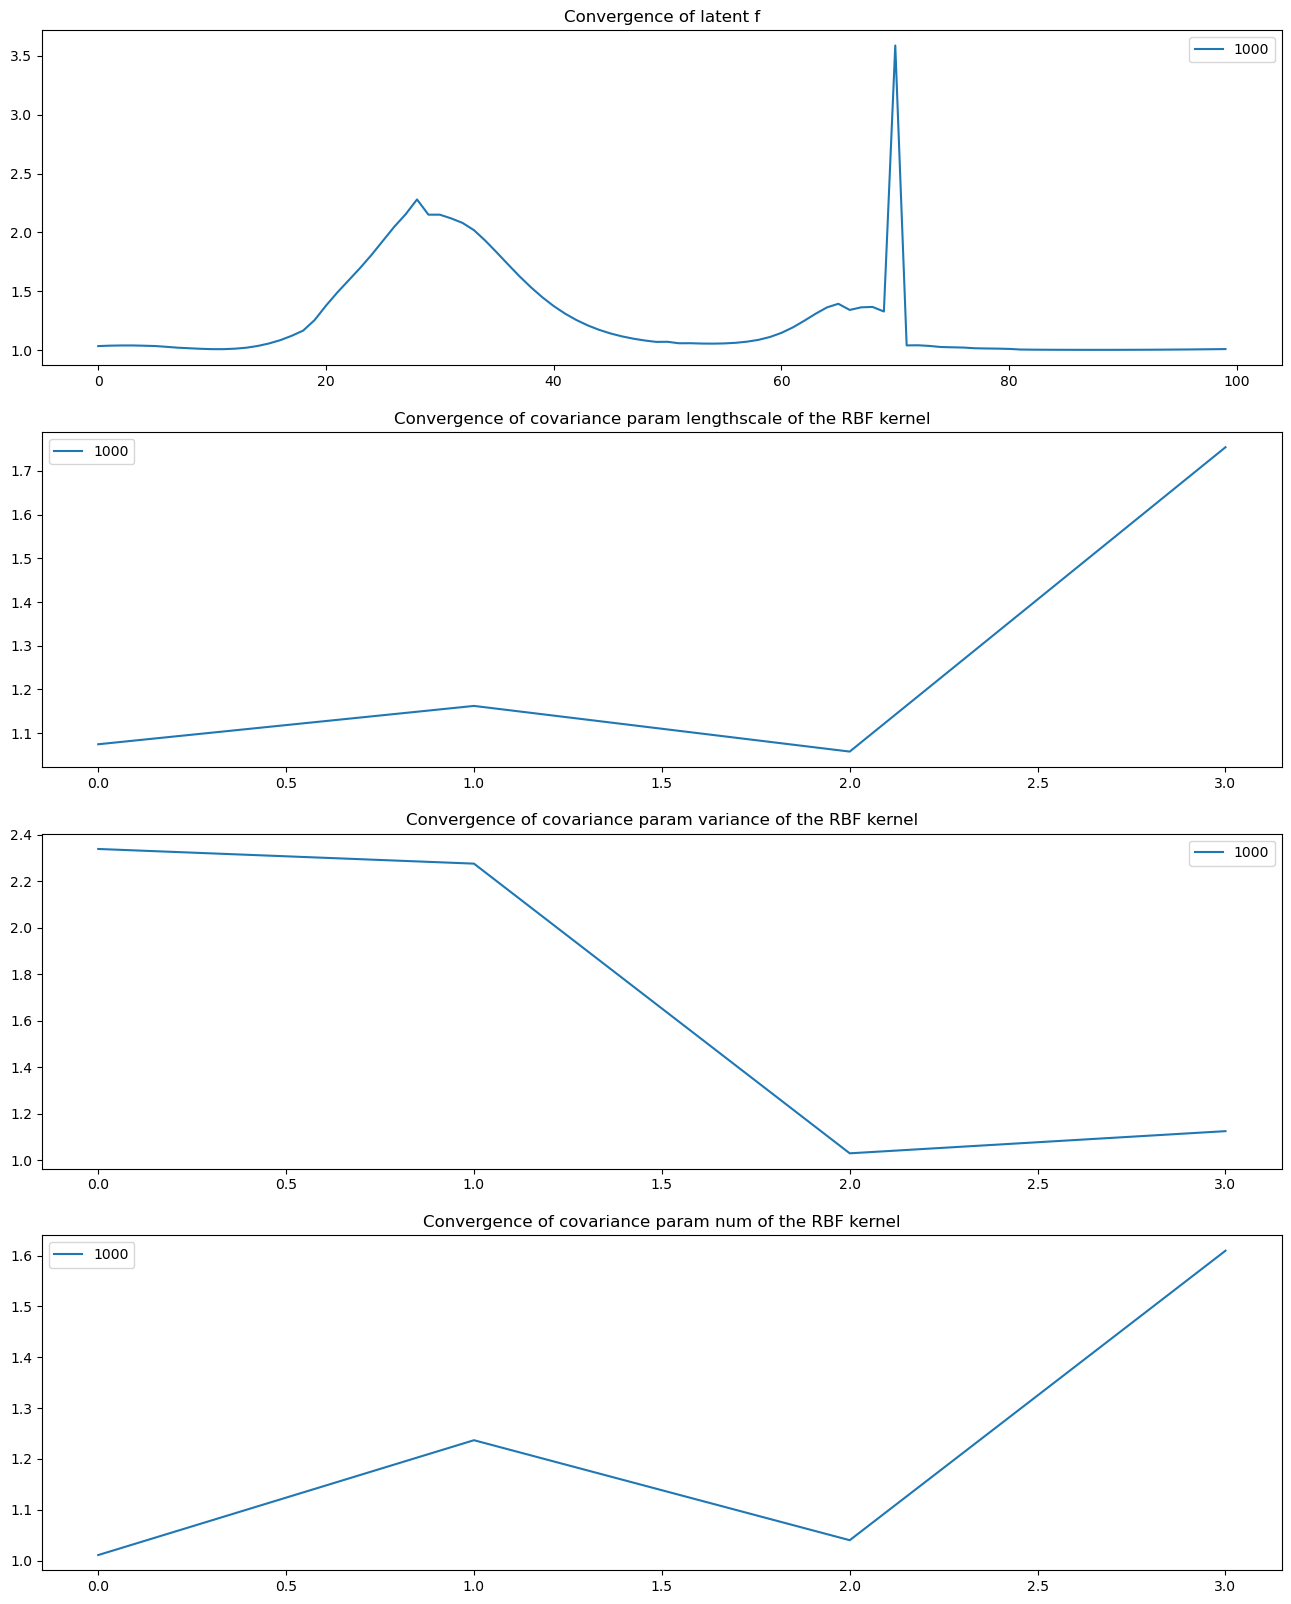

In [33]:
num_mcmc_steps = GP_latent.num_mcmc_steps
priors_flat, priors_treedef = jax.tree_util.tree_flatten(GP_latent.param_priors, lambda l: isinstance(l, (Distribution, Bijector)))
nrows = len(priors_flat)

kernel_names = GP_latent.kernel_name

num_mcmc_steps_vec = jnp.arange(100, 1100, 100)
num_mcmc_steps_vec = None

num_mcmc_steps = 1000
# name = f"_{num_mcmc_steps}_scale1_1000000_new_convergence_all_nogibbs"
name = '/Toy_dataset_Cauchy'

pd_all = []
num_runs = 3

if num_mcmc_steps_vec is not None:
    for j, mcmc_steps in enumerate(num_mcmc_steps_vec):
        pd_all.append([])
        for i in range(num_runs):
            GP_Latent = jnp.load("/home/davcic/CP_Testing/Results" + name + f"/GP_Latent/GP_latent_trained_orig_{i}.npy", allow_pickle = True)[()]
            pd_all[j].append(GP_Latent.particles.particles)
    plot_convergence(pd_all, num_mcmc_steps_vec = num_mcmc_steps_vec, nrows = nrows, kernel_names = kernel_names, latent = True)
else:
    for i in range(num_runs):
            GP_Latent = jnp.load("/home/davcic/CP_Testing/Results" + name + f"/GP_Latent/GP_latent_trained_orig_{i}.npy", allow_pickle = True)[()]
            pd_all.append(GP_Latent.particles.particles)
    plot_convergence(pd_all, num_mcmc_steps_vec = num_mcmc_steps, nrows = nrows, kernel_names = kernel_names, latent = True)       

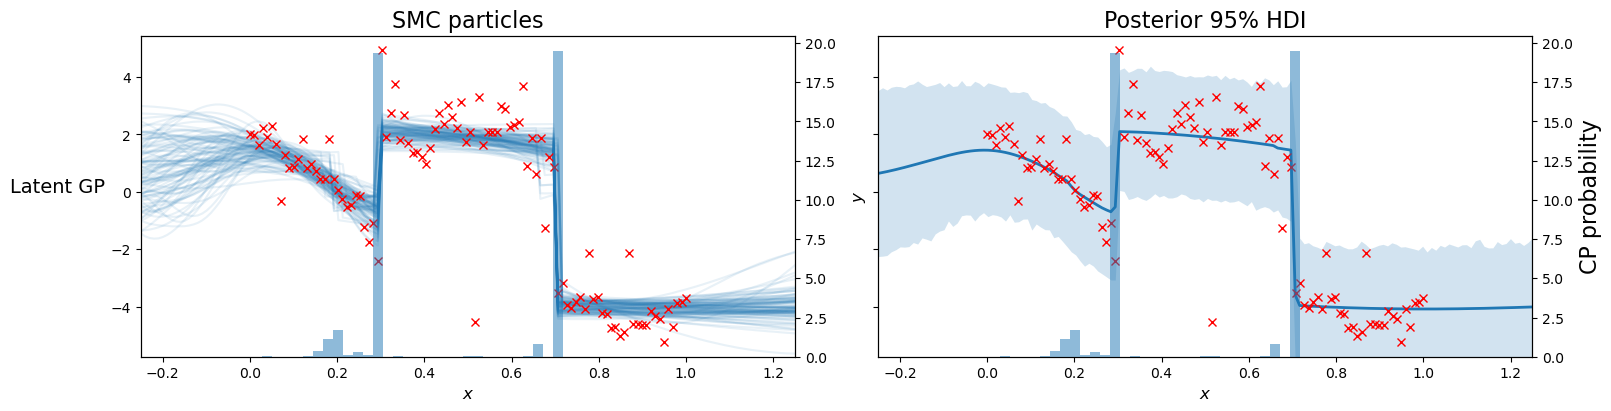

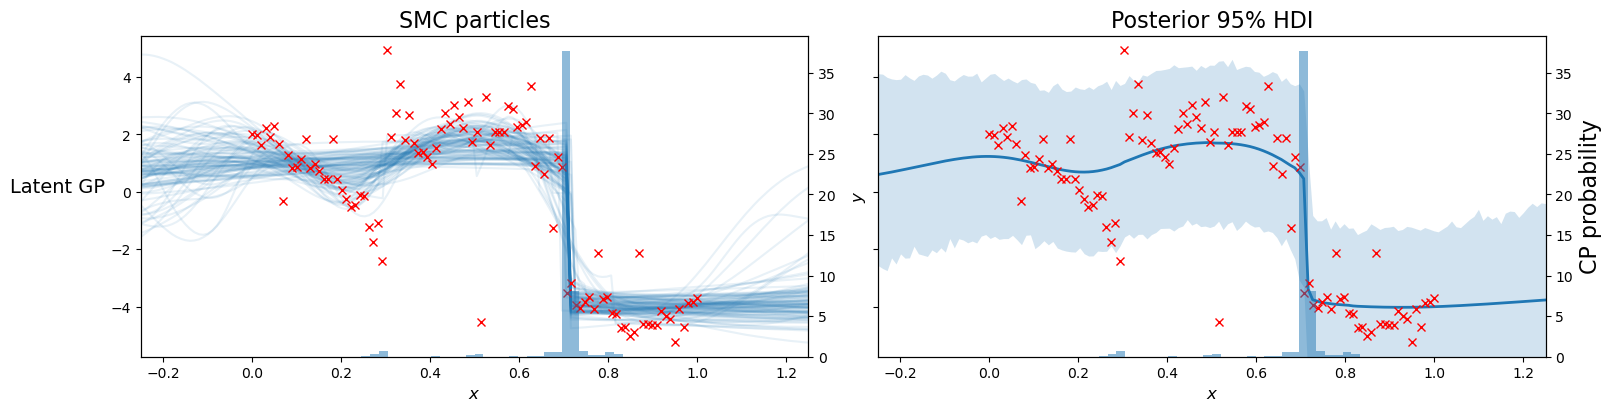

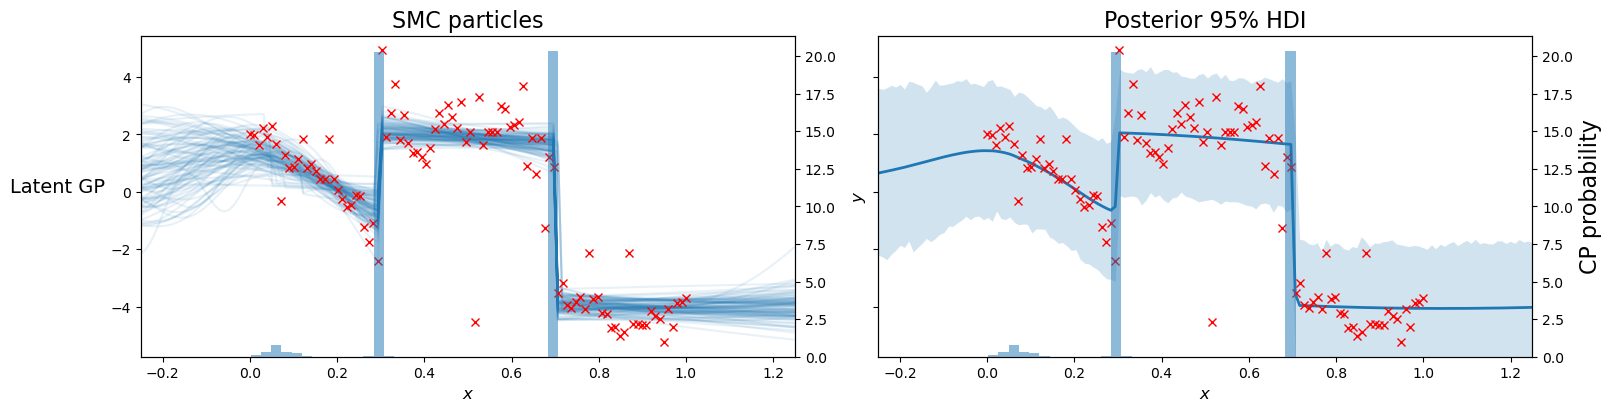

In [34]:
key = jrnd.PRNGKey(1234)
for i in range(num_runs):
    GP_Latent = jnp.load("/home/davcic/CP_Testing/Results" + name + f"/GP_Latent/GP_latent_trained_orig_{i}.npy", allow_pickle = True)[()]
    GP_Latent.plot_fit(key)

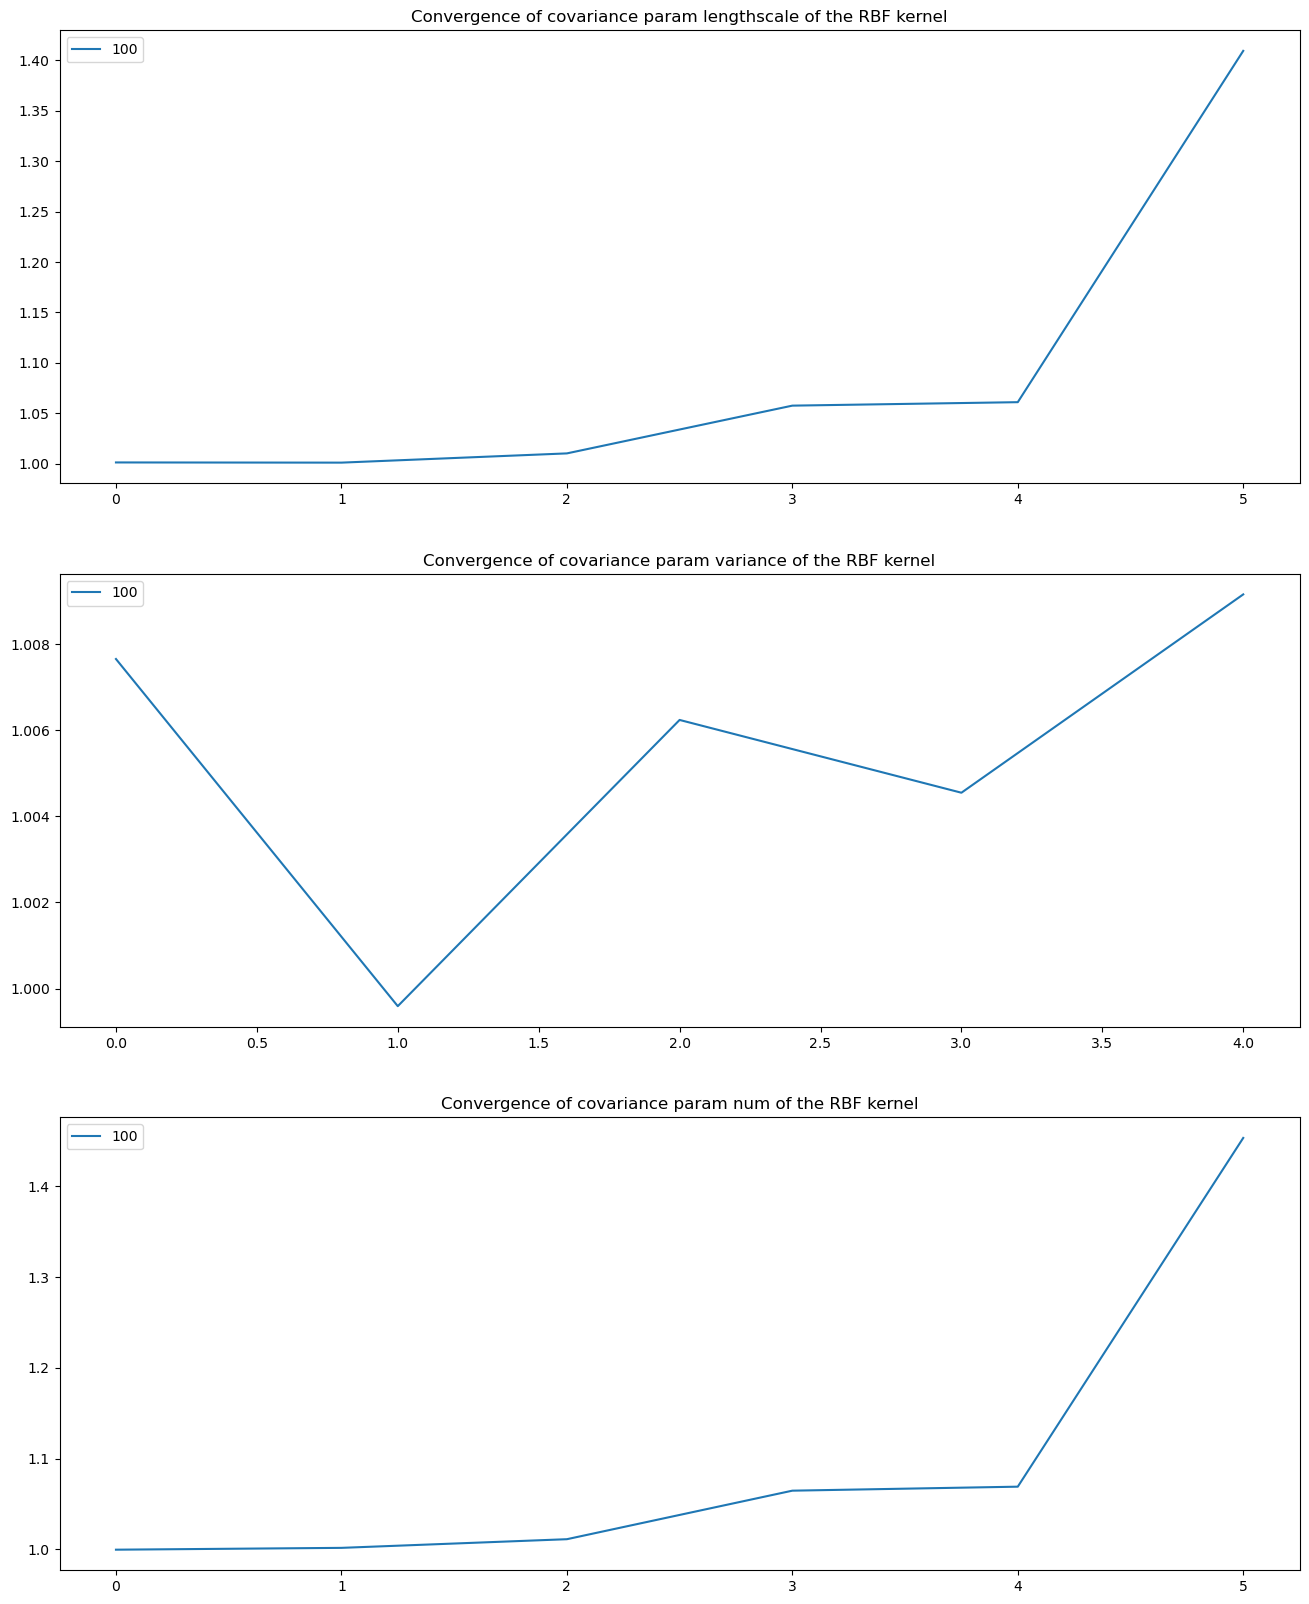

In [43]:


num_mcmc_steps_vec = jnp.arange(100, 1100, 100)
num_mcmc_steps_vec = None

num_mcmc_steps = 1000
# name = f"_{num_mcmc_steps}_scale1_1000000_new_convergence_all_nogibbs"
name = '/Toy_dataset_Cauchy'

pd_all = []
num_runs = 3

if num_mcmc_steps_vec is not None:
    for j, mcmc_steps in enumerate(num_mcmc_steps_vec):
        pd_all.append([])
        for i in range(num_runs):
            GP_marginal = jnp.load("/home/davcic/CP_Testing/Results" + name + f"/GP_Marginal/GP_marginal_trained_orig_{i}.npy", allow_pickle = True)[()]
            pd_all[j].append(GP_marginal.particles.particles)
            num_mcmc_steps = GP_marginal.num_mcmc_steps
            priors_flat, priors_treedef = jax.tree_util.tree_flatten(GP_marginal.param_priors, lambda l: isinstance(l, (Distribution, Bijector)))
            nrows = len(priors_flat)
            kernel_names = GP_marginal.kernel_name
    plot_convergence(pd_all, num_mcmc_steps_vec = num_mcmc_steps_vec, nrows = nrows, kernel_names = kernel_names)
else:
    for i in range(num_runs):
            GP_marginal = jnp.load("/home/davcic/CP_Testing/Results" + name + f"/GP_Marginal/GP_marginal_trained_orig_{i}.npy", allow_pickle = True)[()]
            pd_all.append(GP_marginal.particles.particles)
            num_mcmc_steps = GP_marginal.num_mcmc_steps
            priors_flat, priors_treedef = jax.tree_util.tree_flatten(GP_marginal.param_priors, lambda l: isinstance(l, (Distribution, Bijector)))
            nrows = len(priors_flat)
            kernel_names = GP_marginal.kernel_name
    plot_convergence(pd_all, num_mcmc_steps_vec = num_mcmc_steps, nrows = nrows, kernel_names = kernel_names)       

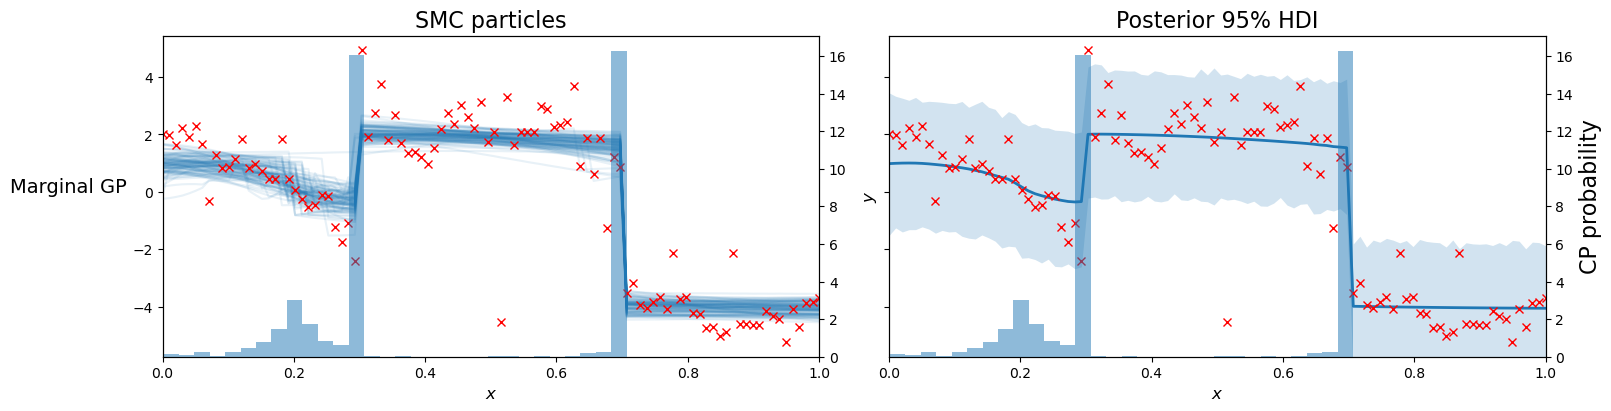

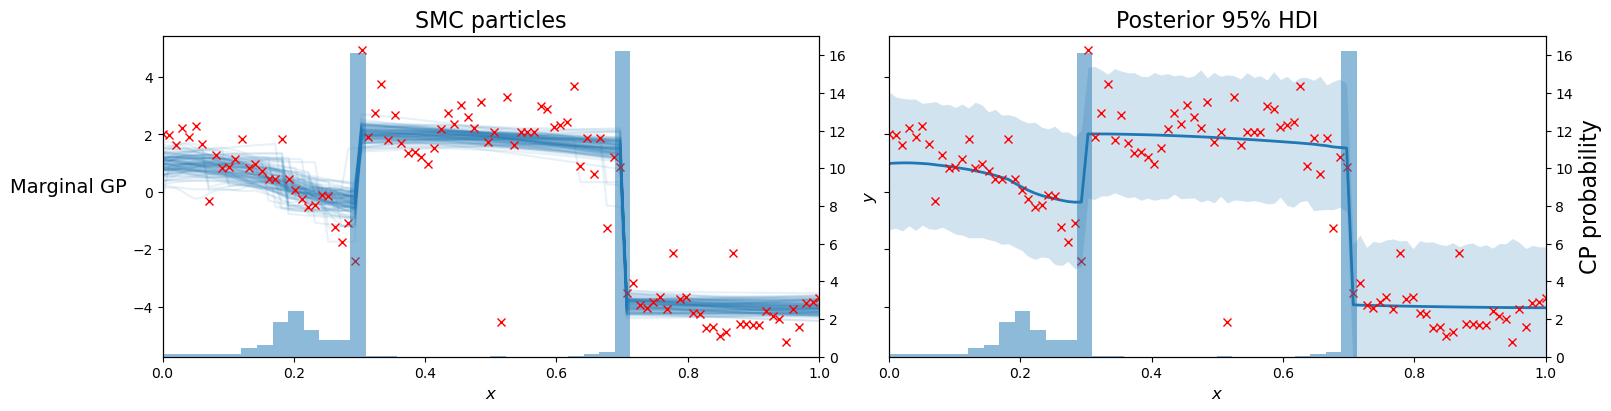

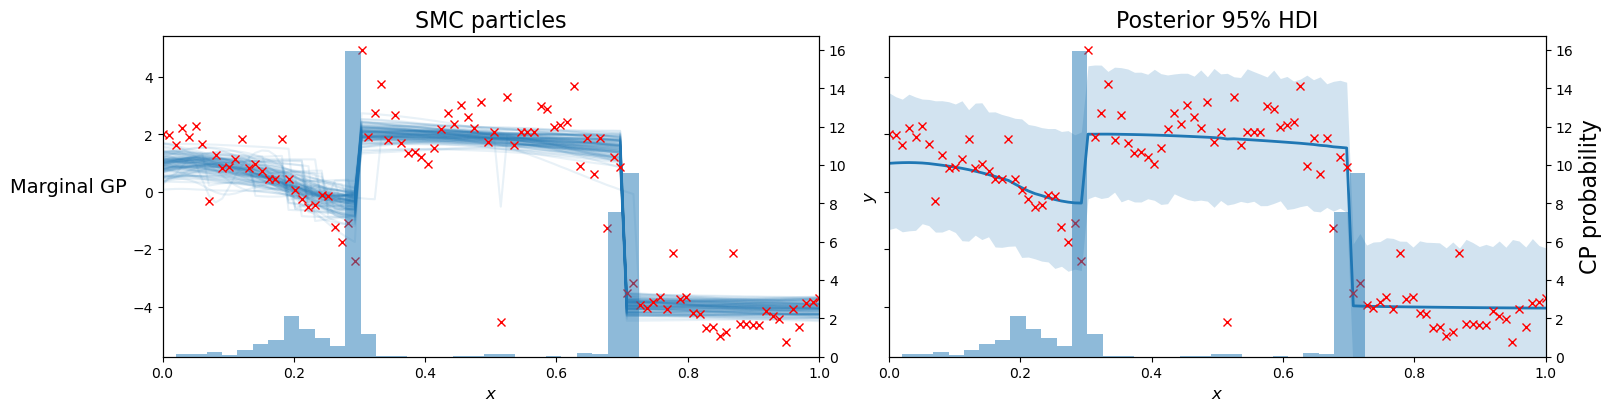

In [39]:
key = jrnd.PRNGKey(1234)
for i in range(num_runs):
    GP_marginal = jnp.load("/home/davcic/CP_Testing/Results" + name + f"/GP_Marginal/GP_marginal_trained_orig_{i}.npy", allow_pickle = True)[()]
    GP_marginal.plot_fit(key)

## Multiple GIbbs step

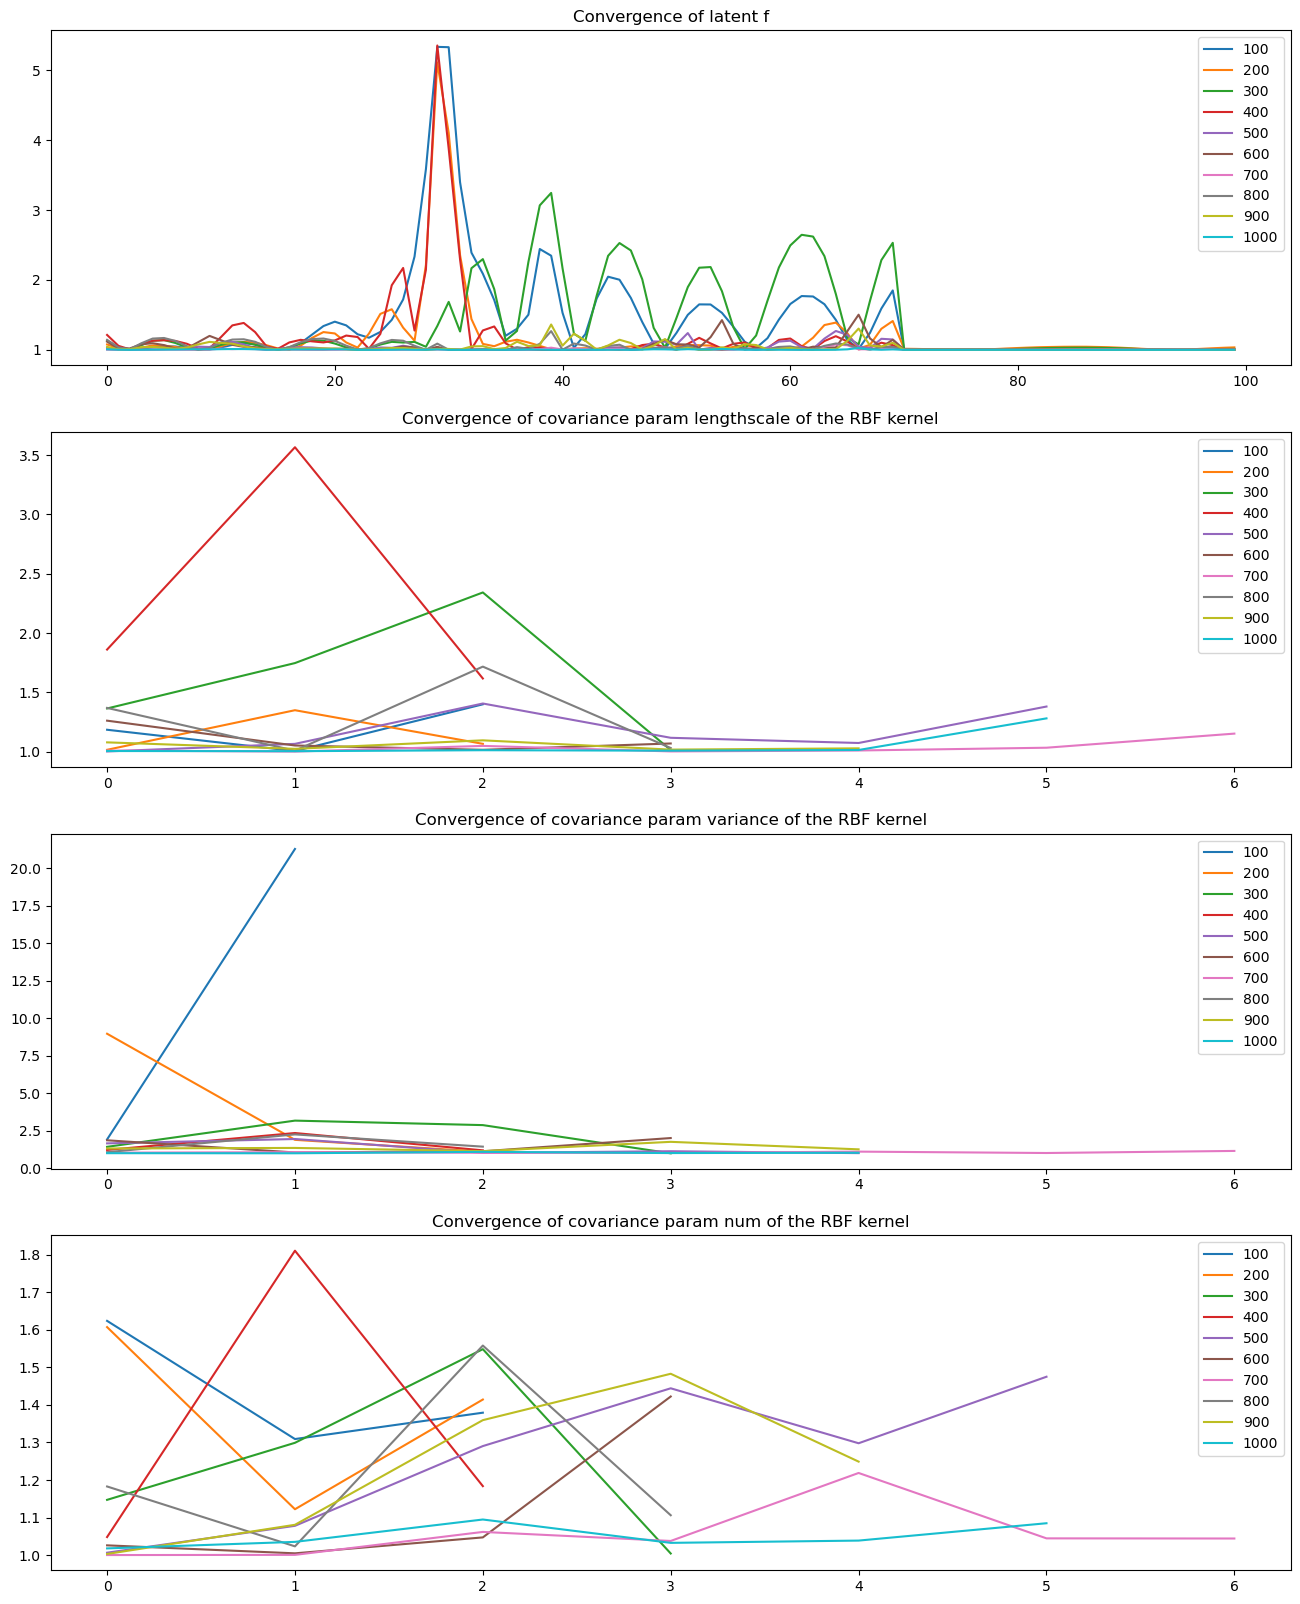

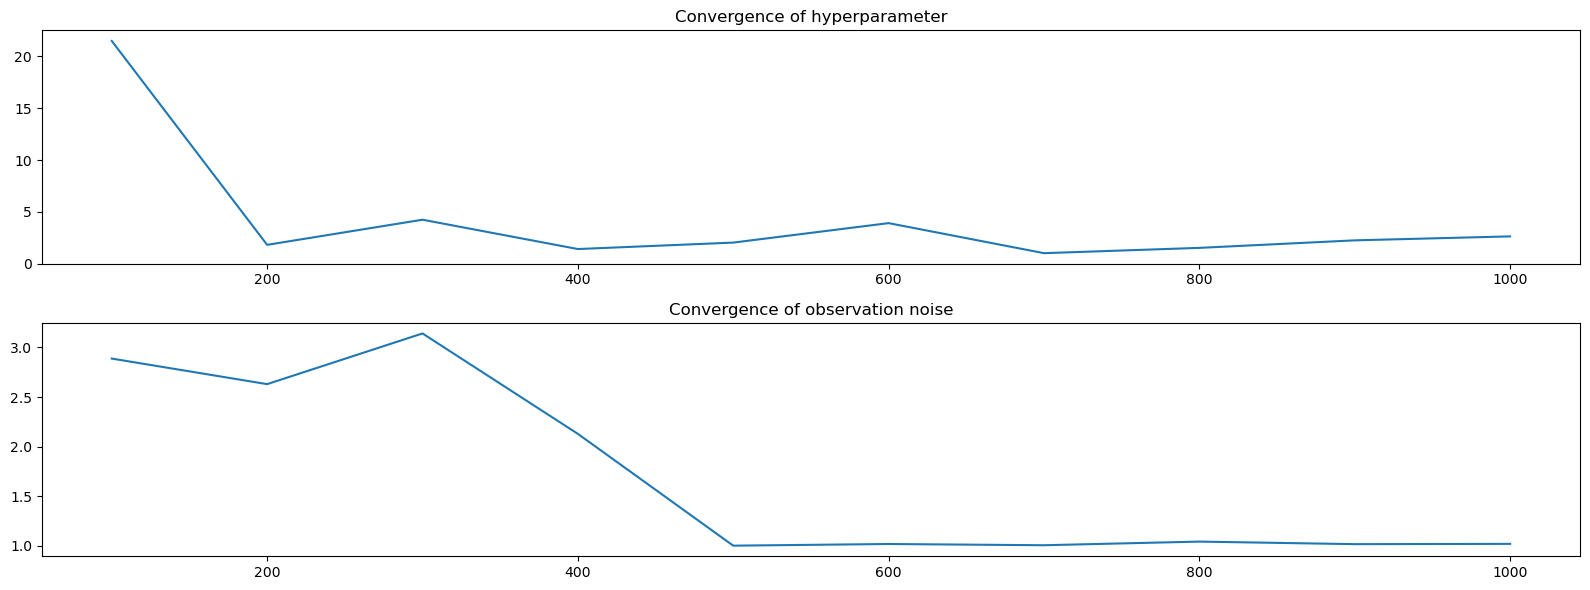

In [30]:
num_mcmc_steps = GP_latent.num_mcmc_steps
priors_flat, priors_treedef = jax.tree_util.tree_flatten(GP_latent.param_priors, lambda l: isinstance(l, (Distribution, Bijector)))
nrows = len(priors_flat)

kernel_names = GP_latent.kernel_name

num_mcmc_steps_vec = jnp.arange(100, 1100, 100)

num_mcmc_steps = 1000
# name = f"_{num_mcmc_steps}_scale1_1000000_new_convergence_all_gibbs"

pd_all = []
num_runs = 3

for j, mcmc_steps in enumerate(num_mcmc_steps_vec):
    pd_all.append([])
    for i in range(num_runs):
        pd_all[j].append(jnp.load("particles_all" + f"_{mcmc_steps}_{i}scale1_1000000_new_convergence_all_gibbs" + ".npy", allow_pickle = True)[()])
plot_convergence(pd_all, num_mcmc_steps_vec = num_mcmc_steps_vec, nrows = nrows, kernel_names = kernel_names, latent = True)

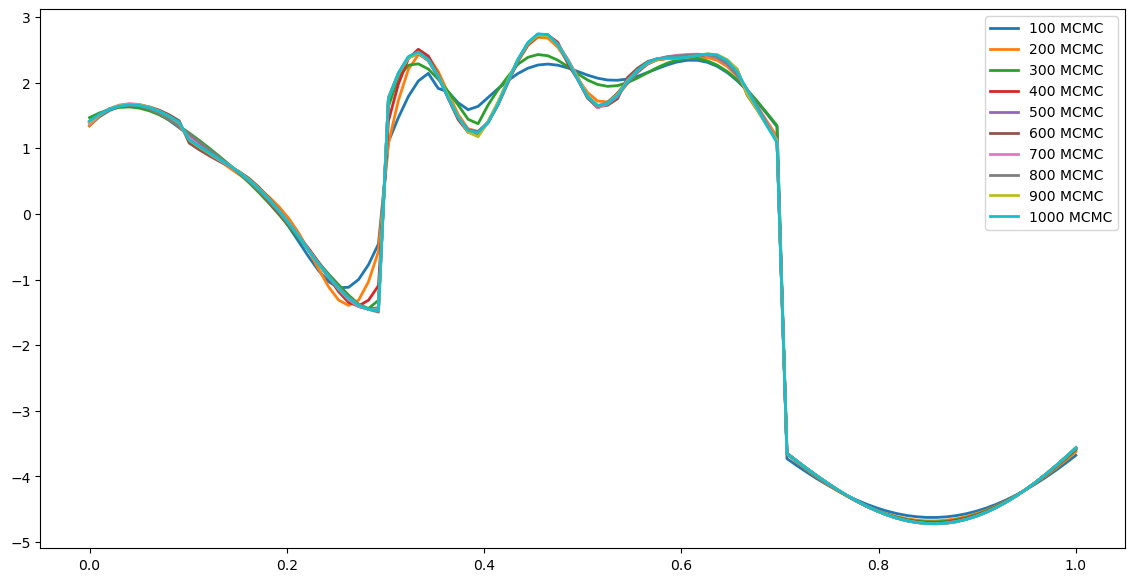

In [34]:
fig, ax1 = plt.subplots(figsize=(14, 7))

colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(len(num_mcmc_steps_vec))]
f_pred = jnp.load('f_pred_100_200_scale1_1000000_new_convergence_all_gibbs.npy')
x_pred = jnp.linspace(0, 1, num=100)
  
for i, (mcmc_step, c) in enumerate(zip(num_mcmc_steps_vec,  colors)):
  #print(i)
  
  f_mean = jnp.mean(f_pred[:, :, :, i], axis=(0, 2))
  # f_hdi_lower = jnp.percentile(f_pred[:, :, i], q=2.5, axis=0)
  # f_hdi_upper = jnp.percentile(f_pred[:, :, i], q=97.5, axis=0)

  ax1.plot(x_pred, f_mean, color=c, lw=2, label = f'{mcmc_step} MCMC')
  # ax1.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
  #                 alpha=0.2, color=c, lw=0)
  # ax2.hist(particles[:, i].T, bins=100, density=True, alpha = 0.3, color = c, label = f'run {i+1}')
  # new_num_all = jnp.reshape(num_all, (num_all.shape[0]* num_all.shape[1], num_all.shape[2]))
  # ax2.hist(new_num_all[:, i].T, bins=100, density=True, alpha = 0.3, color = c, label = f'run {i+1}')
  # ax2.hist(pd[i]['kernel']['num'].flatten(), bins=100, density=True, alpha = 0.3, color = c, label = f'run {i+1}')
plt.legend()
# ax2.set_ylabel('CP Probability')
# ax2.legend()

## Convergence of IHMM
Idea: creata the covariance matrix based on the change points, flatten into an array, compare to true locations \
Use the values of the e.g. last 500 values \
So you will have a (3, 500, N * (N-1)/2) array for convergence

In [45]:
import sys
sys.path.append('/home/davcic/CP_Testing')
sys.path.append('/home/davcic/CP_Testing/HDPHMM')

import hdphmm
from hdphmm import generate_timeseries as gent
import numpy as np
import matplotlib.pyplot as plt
import generate_timeseries as gent2

name = 'Toy_dataset_Cauchy'
num_runs = 3

IHMM = []
for i in range(num_runs):
    IHMM.append(jnp.load('/home/davcic/CP_Testing/Results/' + name + f'/IHMM/ihmm_trained_{i}.npy', allow_pickle = True)[()])

In [46]:
# print(IHMM[0].convergence['z'])
# print(IHMM[0].z[0, :])

# # print(IHMM[0].convergence['nstates'][0])
# print(IHMM[0].convergence['nstates'])

In [47]:
def conv_IHMM(size, estimated_states):
    size_arr = jnp.arange(size)
    carry, CP_loc = jax.lax.scan(lambda carry, x: (x[0], jnp.where(carry != x[0], 1, -1)), estimated_states[0], jnp.concatenate((estimated_states[:, None], size_arr[:, None]), axis = 1))
    # CP_loc = jax.vmap(lambda a, b, c: jax.lax.cond(a != b) in_axes=(0, 0, 0))(estimated_states[:-1], estimated_states[1:], size_arr)
    # CP_loc = jnp.argwhere(estimated_states[:-1] != estimated_states[1:]).flatten()
    # CP_loc = jnp.where(estimated_states[:-1] != estimated_states[1:], )[0]
    # true_matrix = np.zeros((size * (size - 1)/2 ))
    
    # cov_matrix = jnp.zeros((int(size * (size + 1)/2 )))
    new_CP_loc = CP_loc.squeeze()
    # print(new_CP_loc.shape)
    # def check_side(x_, y_):
    #     return 1.0*(jnp.sum(jnp.less(x_, new_CP_loc)) == jnp.sum(jnp.less(y_, new_CP_loc)))      
    # mask = jax.vmap(lambda x_: jax.vmap(lambda y_: check_side(x_, y_))(size_arr))(size_arr)
    
    return new_CP_loc

In [48]:
# import gc
# gc.collect()

run 0
run 1
run 2
[   nan 0.9993 0.9998 0.9996 1.0014 0.9993 1.0032 1.0043 1.0005 1.0016
 0.9998 1.     1.0004 0.9995 0.9999 1.0005 0.9998 0.9991 1.0006 0.9999
 1.0001 1.0007 1.0001 0.9998 0.9998 1.0011 1.0002 0.9991 1.0008 1.0013
 1.0009 1.0002 0.9995 0.9991 0.9994 1.0008 0.9996 0.9998 1.     1.0022
 0.9997 1.0003 0.9997 0.9992 1.0001 1.0013 1.0001 1.001  1.0001 0.9993
 1.0005 1.0021 1.0001 1.0022 1.0036 1.0008 1.0023 0.9996 1.0002 1.0002
 0.9992 1.0042 1.0008 0.9996 0.9993 0.9999 1.0023 1.001  1.0034 1.0016
 1.0006 0.9991 0.9992 0.9998 1.0004 0.9991 1.0018 0.9998 1.0008 0.999
 1.0012 0.999  1.002  0.9995 1.     1.0014 1.0006 1.     0.9995 1.
    nan 0.999  0.999     nan 0.9995 1.0008 1.0025 0.9995 1.    ]


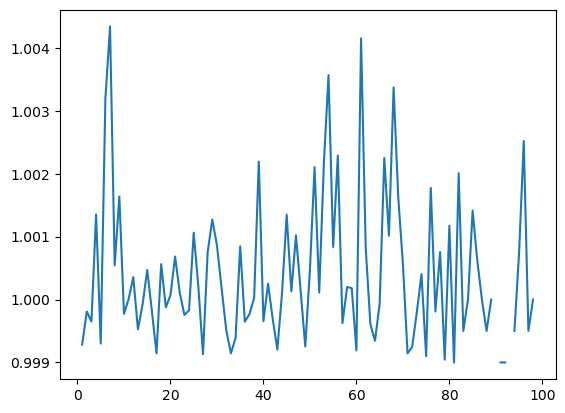

In [49]:
z_size = len(IHMM[0].z[0, :])
size = int(z_size * (z_size + 1)/2 )
num_back_steps = 500
back_steps = jnp.arange(num_back_steps, 0, -1)
conv_array = jnp.zeros((num_runs, num_back_steps, z_size))



for i in range(num_runs):
    print(f'run {i}')
    size = len(IHMM[i].z[0, :])
    conv_z_arr = jnp.array(IHMM[i].convergence['z'])
    estimated_states = conv_z_arr[-num_back_steps:].squeeze()
    # print(estimated_states.shape)
    conv_arr = jax.vmap(conv_IHMM, in_axes = (None, 0))(size, estimated_states)
    # plt.plot(conv_arr.T)
    # plt.show()
    # print(conv_arr.shape)
    conv_array = conv_array.at[i, :, :].set(conv_arr)

convergence_IHMM = potential_scale_reduction(conv_array, 0, 1)
print(convergence_IHMM)
plt.plot(convergence_IHMM)
plt.show()
    # for j in range(back_steps):
    #     print(f'step_back {j}')
    # conv_array = conv_array.at[i, j, :].set(conv_IHMM(IHMM[i], j))
# plt.imshow(conv_arr.squeeze())

Found 9 unique states
[0.9753 0.9294 0.9744 0.9904 0.9712 0.9764 0.9737 0.995  0.9513]


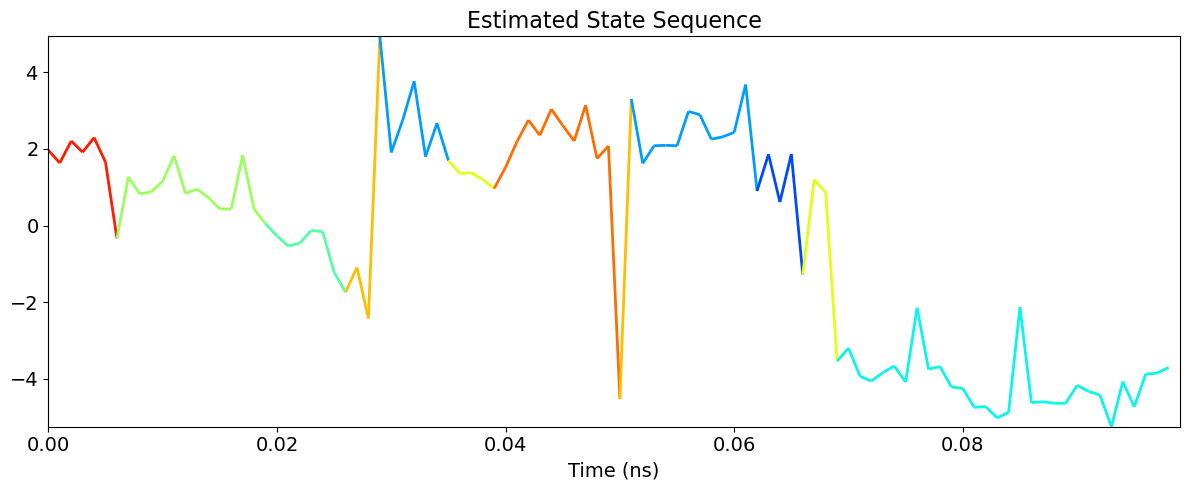

In [50]:
IHMM[0].summarize_results()

Found 11 unique states
[0.9717 0.9802 0.948  0.9356 0.9795 0.9977 0.9281 0.9559 0.9514 0.9615
 0.9565]


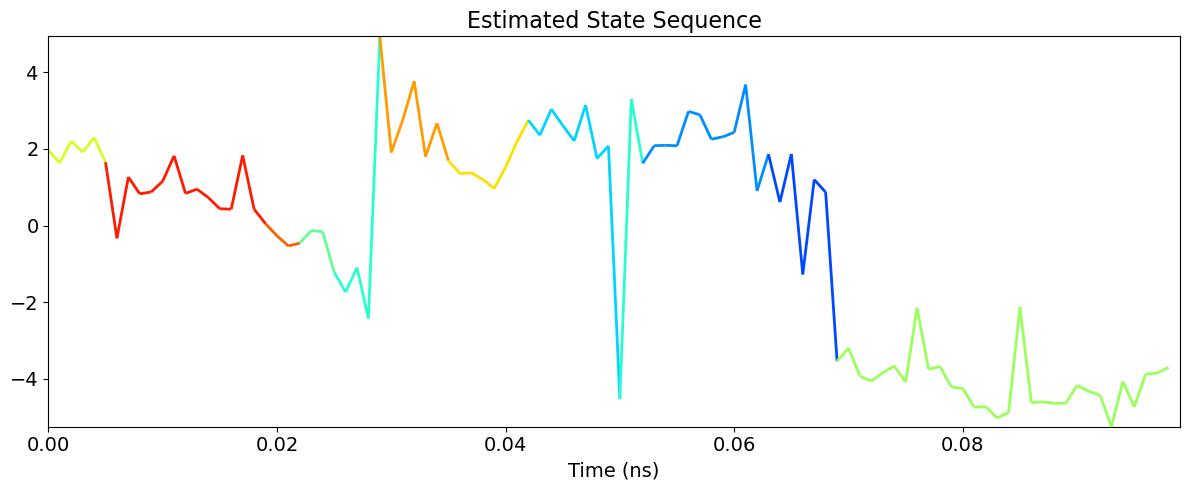

In [51]:
IHMM[1].summarize_results()

Found 10 unique states
[0.9785 0.9916 0.9672 0.9959 0.9911 0.9803 0.9873 0.9826 0.9856 0.9855]


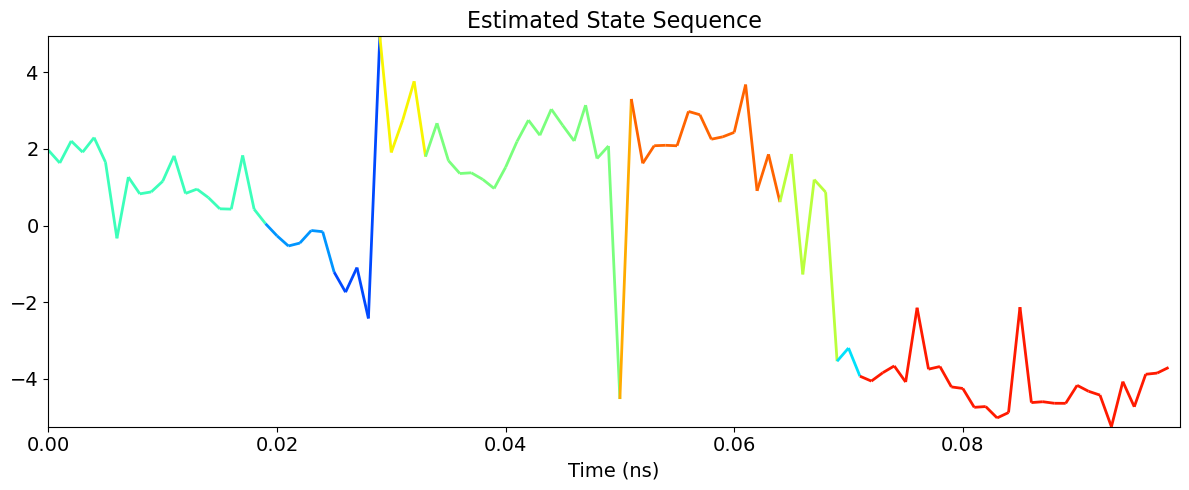

: 

In [52]:
IHMM[2].summarize_results()

In [125]:
conv_z_arr = jnp.array(IHMM[0].convergence['z'])
estimated_states = conv_z_arr[:-num_back_steps][0, :]
estimated_states_sub = estimated_states[0]
jnp.argwhere(estimated_states_sub[:-1] != estimated_states_sub[1:]).flatten()


size = 99
size_arr = jnp.arange(size)

jnp.concatenate((estimated_states_sub[:, None], size_arr[:, None]), axis = 1).shape

(99, 2)

In [140]:
print(IHMM[1].convergence['z'][0])
print(IHMM[1].z[0, :])

[[ 0  0  0  0  0  0  8  8  8 17 17 17 17 17 17 17 17 17 17 17 17 13 13 13
  13 13 13 13 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  8  8  8  4  4  4
   4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
   4  4  4]]
[ 0  0  0  0  0  0  8  8  8 17 17 17 17 17 17 17 17 17 17 17 17 13 13 13
 13 13 13 13 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  8  8  8  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4]


In [139]:
print(IHMM[1].convergence['nstates'][0])
print(IHMM[1].convergence['nstates'][-1])

6
5


## Convergence of GP via same method